# Toy example using pySQUID

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['font.size'] = 16

def cleanup(axis, title=None):
    axis.axis('off')
    if title:
        axis.set_title(title)

Import only the GaussianKernel and TVDeconvolver. GaussianKernel represents an operator which transforms $g$-fields into fluxes, parameterized by the height of the plane of measurement and an $x$ and $y$ width. TVDeconvolver uses this kernel object, requiring only some data and a parameter defining the strength of the prior (how much to penalize oscillations, etc).

This code solves the following optimization problem:
$$ \mathrm{argmin}_g \frac{1}{2\sigma^2} || M g - \phi ||^2 + \gamma \mathrm{TV}(g), $$
given the flux $\phi$ and a prior regularization strength $\gamma$, $g$ is the current-dipole field which minimizes this quantity. The matrix $M$ represents the combination of the convolution of both the Biot-Savart law and the finite-sized probe of the SQUID or other magnetometer, and the function $\mathrm{TV}$ is the measure of the isotropic total variation of the proposed solution.

There is a trade-off between the two terms in this optimization problem. If $\gamma$ is very small and the TV term has no effect on the position of the solution, then only the linear least square problem matters. The solution of 
$$ g^\star = \mathrm{argmin}_g ||Mg-\phi||^2 $$
is 
$$ g^\star = (M^TM)^{-1}M^T\phi. $$
Because $M$ is a convolution and loses information, it has very small eigenvalues associated with large wavenumbers, precisely where noise in the data is present. Therefore this solution is unstable and in fact a huge space of solutions will minimize the least square problem to be $0$ to arbitrary precision. Therefore we must impose some kind of constraint on this space of solutions, preferring solutions which have some physical significance. The Total Variation function prefers patches of constant values, or in this problem patches of constant linear slope so that the solved current densities have patches of constants. In this way ringing is minimized, while sharp edges which are common in realistic samples are not penalized. It is the goal of this notebook to investigate for a very simple problem the process of selecting $\gamma$ to best extract the true current distribution from a flux image.

In [2]:
from pysquid.kernels.magpsf import GaussianKernel
from pysquid.infercurrents.deconvolve import TVDeconvolver

## Construct synthetic data

In [3]:
params = np.array([1., 1., 1.])  # height, sigma_x, sigma_y
sigma = 0.01  # noise in the image, as a percentage of signal strength
Ly, Lx = 16, 16
padding = np.array([2, 2])
phishape = np.array([Ly, Lx])
gshape = phishape + 2*padding
Ly_pad, Lx_pad = gshape

### Define the kernel object which can transform g-fields into fluxes

In [4]:
kern = GaussianKernel(phishape, padding=padding, params=params, edges=True)

In [5]:
gtrue = np.zeros(gshape)
gtrue[8:-8, 8:-8] = 1.

phitrue = kern.applyM(gtrue).real
scale = phitrue.ptp()

# Everything is nicer when its order 1
phitrue /= scale
gtrue /= scale
data = phitrue + sigma * np.random.randn(*phishape)

A $g$-field which is a constant in a circle represents an electric current circulating around a circle. The right-hand-rule sets the orientation, and because the square is larger in $g$ than its surroundings the current circulates counter-clockwise.

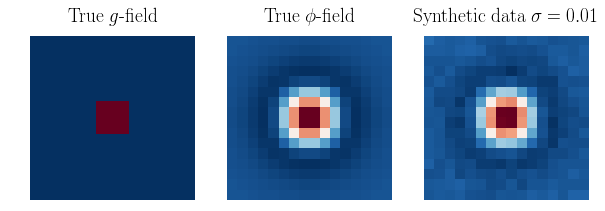

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))

axes[0].matshow(gtrue);cleanup(axes[0], "True $g$-field")
axes[1].matshow(phitrue);cleanup(axes[1], "True $\phi$-field")
axes[2].matshow(data);cleanup(axes[2], "Synthetic data $\sigma={}$".format(sigma))

Defining the deconvolver object. The noise sets the scale in this problem, and so a good first guess of the correct regularization strength is of order $\sigma^2$.

In [7]:
decon = TVDeconvolver(kern, gamma=sigma**2)

In [58]:
gsol0 = decon.deconvolve(data.ravel(), iprint=1, eps_abs=1E-8, eps_rel=1E-8)
gsol = gsol0.reshape(gshape)

Initial cost = 4.258e+00
Iteration limit reached
Final cost = 2.521e-02


True noise = 0.0100,  Residual error = 0.01


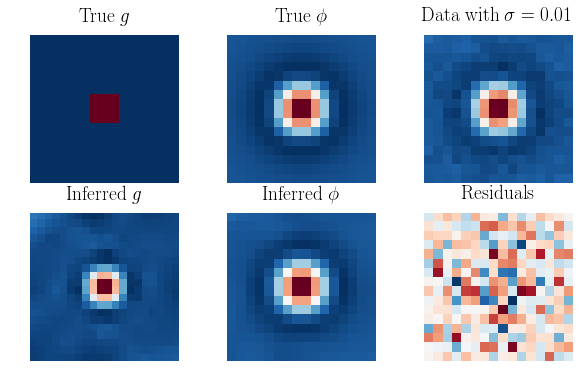

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(10,6))

axes[0,0].matshow(gtrue); cleanup(axes[0,0], "True $g$")
axes[0,1].matshow(phitrue); cleanup(axes[0,1], "True $\phi$")
axes[0,2].matshow(data); cleanup(axes[0,2], "Data with $\sigma={}$".format(sigma))

axes[1,0].matshow(gsol0.reshape(gshape)); cleanup(axes[1,0], "Inferred $g$")
phisol = decon.M.dot(gsol0).reshape(phishape)
axes[1,1].matshow(phisol); cleanup(axes[1,1], "Inferred $\phi$")
axes[1,2].matshow(phisol - data); cleanup(axes[1,2], "Residuals")
print("True noise = {:.4f},  Residual error = {}".format(np.std(phisol-data), sigma))

Notice that the standard deviation between the model $Mg$ and data $\phi$ is 0.01, while the true noise is 0.01. This is one number we want to aim for, but if we examine the residuals, they clearly are not perfect noise as there is a cluster of higher-magnitude values in the center. Our regularization parameter is a little too large.

### Show a line cut to more clearly understand performance

Text(0,0.5,'$g$-field')

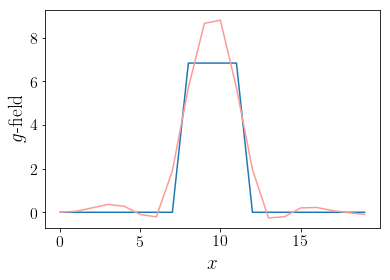

In [37]:
plt.plot(gtrue[10])
plt.plot(gsol[10]-gsol[10,0])
plt.xlabel("$x$")
plt.ylabel("$g$-field")

### Discussion
Convolutions throw away information below some length scale set by the kernel size. In our problem the Gaussian PSF sets the scale, and in general its not possible to reconstruct information below this length scale without a lot of extra information. Later we'll explore imposing a finite-support constraint, telling it where there are no currents, and we'll see improved performance as a result.

## Systematically choosing regularization strength
The theory behind this is an extended discussion of something commonly called the l-curve method. Basically one computes the solution to the inference problem for many values of $\gamma$, usually exponentially distributed (so that you are searching uniformly in logarithm and thus looking in a scale-invariant way). When you see the value of the cost function (the first equation at the top) start to increas precipitously as a function of $\gamma$, you know that the TV term is dominating, as the optimum is more defined by minimizing the TV than by minimizing the similarity to the data. If $\gamma$ is small we've seen that the data similarity term can be arbitrarily small, so for small gamma we expect the cost function to be very small, and as the TV term increases in importance there will be sacrifices made in predicting the data in order to minimize the total variation. So basically the l-curve tells us the region in which to look for the optimal regularization, the point at which the cost starts to increase. Then we must examine each solution, seeing that both the standard deviation of the residuals is about equal to the noise in the data, and the residuals themselves look as close to pure noise as possible. If the standard deviation of the residuals is smaller than $\sigma$ we must increase $\gamma$, and if the residuals have non-random structure we must decrease $\gamma$. There are other, more systematic ways to choose $\gamma$ which rely on sophisticated tools from Bayesian probability theory but these rely on integrating partition functions which is not really possible with our choice of TV prior.

In [11]:
scale = np.log10(sigma**2)
gammalist = 10**(np.linspace(scale-2, scale+2, 20))
print(gammalist)

[1.00000000e-06 1.62377674e-06 2.63665090e-06 4.28133240e-06
 6.95192796e-06 1.12883789e-05 1.83298071e-05 2.97635144e-05
 4.83293024e-05 7.84759970e-05 1.27427499e-04 2.06913808e-04
 3.35981829e-04 5.45559478e-04 8.85866790e-04 1.43844989e-03
 2.33572147e-03 3.79269019e-03 6.15848211e-03 1.00000000e-02]


In [20]:
gsol_list = []
nlnproblist = []
residual_list = []

for gamma in gammalist:
    print("Solving gamma={}".format(gamma))
    d = TVDeconvolver(kern, gamma=gamma)
    gsol = d.deconvolve(data.ravel(), iprint=0, eps_abs=1E-10, eps_rel=1E-10)
    phisol = d.M.dot(gsol)-data.ravel()
    residual_list.append(phisol)
    gsol_list.append(gsol.reshape(gshape))
    nlnproblist.append(decon.nlnprob(data, gsol))
    print("\t nlnprob={}".format(nlnproblist[-1]))
    

Solving gamma=1e-06
	 nlnprob=0.031381285485466606
Solving gamma=1.6237767391887209e-06
	 nlnprob=0.028943813265057003
Solving gamma=2.6366508987303555e-06
	 nlnprob=0.02842616714301422
Solving gamma=4.281332398719396e-06
	 nlnprob=0.02747436036563341
Solving gamma=6.951927961775606e-06
	 nlnprob=0.027241468659235612
Solving gamma=1.1288378916846883e-05
	 nlnprob=0.02627016124355553
Solving gamma=1.8329807108324375e-05
	 nlnprob=0.026183359384138936
Solving gamma=2.9763514416313192e-05
	 nlnprob=0.025273172807316877
Solving gamma=4.8329302385717524e-05
	 nlnprob=0.024239226962399635
Solving gamma=7.847599703514606e-05
	 nlnprob=0.025342416926398794
Solving gamma=0.00012742749857031334
	 nlnprob=0.024540953537590872
Solving gamma=0.00020691380811147902
	 nlnprob=0.024566514707344944
Solving gamma=0.0003359818286283781
	 nlnprob=0.026527534805849826
Solving gamma=0.0005455594781168515
	 nlnprob=0.027329920132485162
Solving gamma=0.0008858667904100823
	 nlnprob=0.02962669343735913
Solving

Text(0,0.5,'Residual standard error')

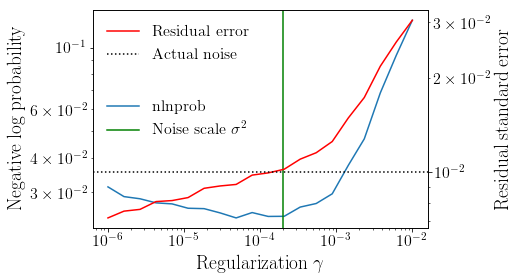

In [60]:
fig, axe = plt.subplots()
axe.loglog(gammalist, nlnproblist, label='nlnprob')
axe.axvline(2*sigma**2, c='g', label="Noise scale $\sigma^2$")
plt.legend(loc='center left')
axe2 = axe.twinx()
axe2.loglog(gammalist, np.std(residual_list, 1), c='r', label="Residual error")
axe2.axhline(sigma, c='k', linestyle='dotted', label="Actual noise")
plt.legend()

axe.set_xlabel("Regularization $\gamma$")
axe.set_ylabel("Negative log probability")
axe2.set_ylabel("Residual standard error")

### Discussion
The bend in this l-curve (blue line) is the place to start examining solutions. Notice that this is also roughly where the residual error (red curve) matches the true noise (black dotted), and note that these correspondences occur quite close to the scale set by $\sigma^2$ (green curve).

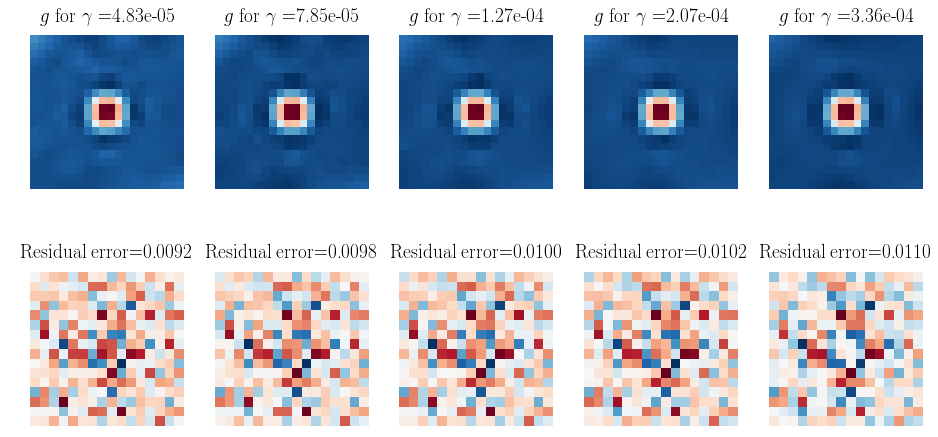

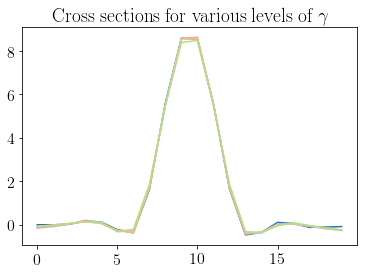

In [51]:
gmin = np.argmin(nlnproblist)+2

orders = np.arange(gmin-2, gmin+3)
fig, axes = plt.subplots(2, len(orders), figsize=(16, 8))

fig2, axes2 = plt.subplots()

for a, o in zip(axes.T, orders):
    gsol = gsol_list[o]
    res = residual_list[o]
    a[0].matshow(gsol);cleanup(a[0], "$g$ for $\gamma=${:.2e}".format(gammalist[o]))
    a[1].matshow(res.reshape(phishape));cleanup(a[1], "Residual error={:.4f}".format(np.std(res)))

    axes2.plot(gsol[10])

axes2.set_title("Cross sections for various levels of $\gamma$");

### Discussion
While these levels of gamma produce similar solutions and have similar residuals, there are noticeable differences. For instance, on the far left ($\gamma$=4.8E-5) there are oscillations outside of the center which are more damped on the far right side ($\gamma$=3.36E-5). My judgement would be that the best solution is the second from the right solution corresponding to $\gamma$=2.07E-4, which is $\approx 2\sigma^2$, the natural scale of the problem. It has residuals which are mostly noise, is residual error is close to $\sigma$ and it has a mostly smooth solution.